# Train Multi-period Market Surrogates

In this notenook, we proposed a surrogate-based framework to caputre the market interactions of individual integrated energy systems (IES). 

First we sample several points from the domain of design variables of IES. Then we fix the IES to sampled points and run an annual simulation using production cost models (PCM), Prescient. We collect the day-ahead and real-time dispatch and LMP data and store them in csv files.

We have three case studies in total. A nuclear energy case study (NE), a renewable energy case study and a fossil energy case study (FE). The detailed case study model can be visited in DISPATCHES repository.

### Import packages

In [1]:
from dispatches.workflow.train_market_surrogates.dynamic.Simulation_Data import SimulationData
from dispatches.workflow.train_market_surrogates.dynamic.Train_NN_Surrogates import TrainNNSurrogates
from dispatches.workflow.train_market_surrogates.dynamic.Time_Series_Clustering import TimeSeriesClustering
from dispatches_data.api import path
import numpy as np
import matplotlib.pyplot as plt
import pathlib

### Set parameters

We need to provide the path of simulation data. Here you can download the data from DISPATCHES using 

pip install git+https://github.com/gmlc-dispatches/dynamic-sweep-data

In [2]:
# path_to_data_package is a standard pathlib.Path object
path_to_data_package = path("dynamic_sweep")

# subdirectories and files can be accessed using the pathlib.Path API
dispatch_data_path = path_to_data_package / "NE" / "Dispatch_data_NE_Dispatch_whole.csv"
 
input_data_path = path_to_data_package / "NE" / "sweep_parameters_results_NE_whole.h5"
assert dispatch_data_path.is_file()

We have to indicate the type of the case study. It should be one of 'RE'(renewable energy), 'NE'(nuclear energy) or 'FE'(fossil energy). 

For NE case study, we have an existing baseload nuclear generator with a low-temperature electrolysis unit.
The electrolyzer enables the nuclear generator to ramp down the power output
to the electricity market, and participate in the hydrogen market during periods
of low electricity demand. 

![NE case study](NE_case_study/NE_PEM_model.png)

In [3]:
case_type = 'NE'

Also, some parameters needs to be specified.

num_clusters: number of clusters for the k-means clustering.

num_sims: number of Prescient simulations we want to have for clustering.

filter_opt: If we want to have 'filter' for the clustering. The filter will exclude the days that thee generator is fully on or off. 

In [4]:
num_clusters = 30        # number of clusters for the k-means clustering.
num_sims = 192        # number of Prescient simulations we want to have for clustering
filter_opt = True        # If we want to have 'filter' for the clustering.

### Create simulation_data object

Create an object using SimulationData class. This object will process and store the data for clustering and training neural networks.

In [5]:
simulation_data = SimulationData(dispatch_data_path, input_data_path, num_sims, case_type)

We can read the data for the csv file and return two dictionaries where keys are the simulation index and values are the time series real-time dispatch data or simulation input data. 

In [6]:
dispatch_dict, input_dict = simulation_data.read_data_to_dict()
print(dispatch_dict[0])
print(input_dict[0])

[380. 380. 380. ... 400. 400. 400.]
[1.5e+01 5.0e-02 1.0e+01 5.0e+02]


Also, you can read the real-time wind generator power generation by 'read_wind_data' function. It will return an array where contains the time series data with shape of (366,24). (366 days with 24 hours in each day)

In [7]:
wind_data = simulation_data.read_wind_data()
print(np.shape(wind_data))

(366, 24)


### Create clustering_trainer object

Create an object for time series clustering. 

Three arguments are necessary: simulation_data, num_clusters, filter_opt.

simulation_data is the object that we created above.

In [8]:
clustering_trainer = TimeSeriesClustering(simulation_data, num_clusters, filter_opt)

We can return the trained clustering model by the function.

In [9]:
clustering_model = clustering_trainer.clustering_data()

The number of zero capacity days in the dataset is 27062
The number of full capacity days in the dataset is 3531


The real-time dispatch data are scaled to capacity factors before the clustering. There is a private function in this class to do the work. For NE case study, the capacity factor are between 0 and 1. When the capacity factor is 0 the nuclear generator is working at $P_{min}$, where $P_{min} = P^{gen}_{max} - P^{pem}_{max}$. $P^{gen}_{max}$ is the max capacity of the generator and $P^{gen}_{max}$ is the max capacity of PEM. 

To save the model, we can can call "save_clustering_model". If we don't give a path, the model will be saved to the working directory. The function will return the path of saved clustering model.

In [10]:
# result_path = clustering_trainer.save_clustering_model(clustering_model)
result_path = str(pathlib.Path('NE_case_study/NE_result_192years_30clusters_OD.json'))

Cluster centers are important information for us. You can get those values by "get_cluster_centers". The function will return a dictionary where keys are cluster index and values are cluster centers (time series)

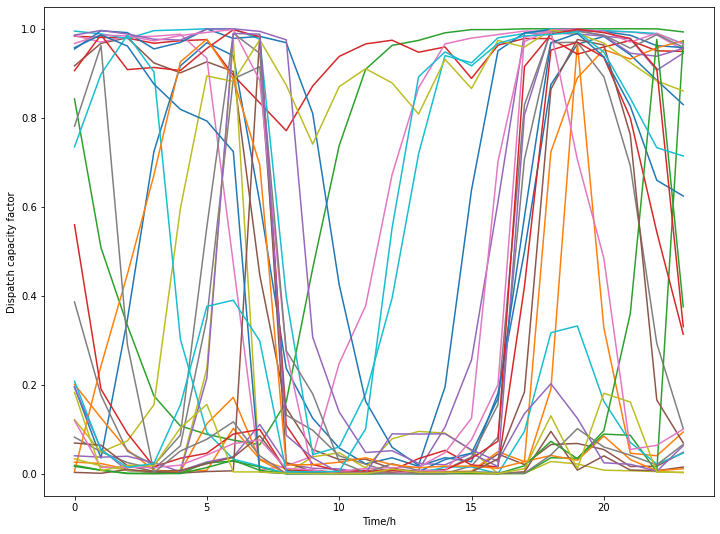

In [11]:
center_dict = clustering_trainer.get_cluster_centers(result_path)

for i in range(num_clusters):
    plt.plot(center_dict[i])
plt.xlabel('Time/h')
plt.ylabel('Dispatch capacity factor')
plt.show()

### Create surrogate_trainer object 

Create an object to train the market surrogates. 

Three arguments are necessary: simulation_data, data_file, filter_opt.

The data_file is a path. For if you want to train a revenue surrogatem, this data_path is the path of revenue csv file. If you want to train a dispatch frequency surrogate, this data_path is the path of saved clustering model.

In [12]:
surrogate_trainer = TrainNNSurrogates(simulation_data, result_path, filter_opt)

To train the dispatch frequency surrogate, we can call 'train_NN_frequency' function. You need to give a list of neural network size. 

For example, we give [4,75,75,75,32] here. 4 is the number of nodes in the input layer, 32 is number of nodes in output layer (number of representative day). We have 3 hidden layers with 75 nodes each. 

If you have filter_opt = True, the number of representative day will be num_clusters + 2 where 2 corresponds to the zero/full days. 

The function will print the $R^2$ result for each representative day. 

In [13]:
model_df = surrogate_trainer.train_NN_frequency([4,75,75,75,32])

Making NN Predictions...
Evaluate on test data
2/2 [==============================] - 0s 1ms/step - loss: 0.0825
0.08251975476741791
2/2 [==============================] - 0s 1ms/step
The R2 of dispatch surrogate validation is [0.9989807572567754, 0.9195106356137187, 0.9782616859946545, 0.9482914871901337, 0.9534049294253228, 0.9748667211817922, 0.7623754710380003, 0.9813145200458163, 0.932079755000075, 0.88119231733833, 0.9866646654042197, 0.9901543189902491, 0.9550007170260163, 0.9041126851595744, 0.9585682137492805, 0.9910971153220763, 0.9360610980088924, 0.9919506493271321, 0.964832898638907, 0.9727630565191323, 0.7106237287845176, 0.9576939969602464, 0.9302283326232771, 0.9101037421779389, 0.827072154228201, 0.8399282348457692, 0.9896055965549824, 0.9633592380884979, 0.7089304789077371, 0.9313112338903713, 0.9112210271674019, 0.9862573525188446]


To save the model, we need two path. One is NN_model_path in which we save the keras NN model. Another is NN_param_path in which we save the scaling parameter for features. If not given, the model will be saved to the default path. 